### Computer Vision class                                        
Professor Lee Chilwoo                                     
Student: Tran Dinh Son, Id: 177290   
Chonnam National University        
##### Project Evaluation: Face Recognition using Ensemble Learning

## Import library

In [21]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.externals.six.moves import zip
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import pandas as pd
import seaborn as sn
print(__doc__)

Automatically created module for IPython interactive environment


## Dataset: LFW Face Dataset

In [2]:
lfw_people = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1140
n_features: 1850
n_classes: 5


In [3]:
###############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
print("-------------------------")
print("Size of training set: ", X_train.shape[0])
print("Size of testing set: ", X_test.shape[0])

-------------------------
Size of training set:  798
Size of testing set:  342


## Feature Extraction by PCA

In [4]:
###############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 100

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 100 eigenfaces from 798 faces
done in 0.103s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s


Examples of feature extraction by PCA


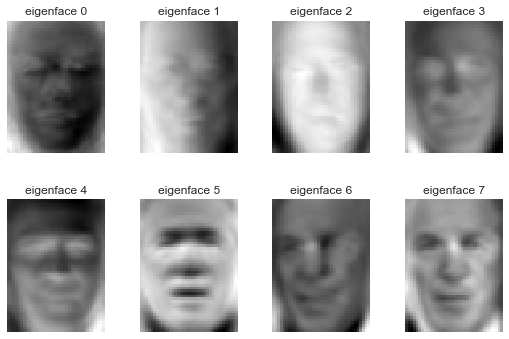

In [27]:
# Examples of feature extraction by PCA
def plot_gallery(images, titles, h, w, n_row=2, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

print("Examples of feature extraction by PCA")
plt.show()

# Model 1: SVM

In [13]:
print("Fitting the classifier to the training set")
clf = SVC(kernel='rbf', probability=True)
clf = clf.fit(X_train_pca, y_train)
#print("done in %0.3fs" % (time() - t0))
#print("Best estimator found by grid search:")
#print(clf.best_estimator_)
print("Test Accuracy: ")
y_pred_SVM = clf.predict(X_test_pca)
print(accuracy_score(y_test, y_pred_SVM))

Fitting the classifier to the training set
Test Accuracy: 
0.8801169590643275


# Model 2: MLP

In [6]:
from sklearn.neural_network import MLPClassifier
# #############################################################################
# Train a classification model 
print("Train a classification model")
t0 = time()
param_grid_MLP = {'alpha': [1e-3, 5e-3, 1e-4, 5e-4, 1e-5],
              'hidden_layer_sizes': [(90,90),(20,20),(30,30)], }
clf_MLP = GridSearchCV(MLPClassifier(), param_grid_MLP)
clf_MLP = clf_MLP.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf_MLP.best_estimator_)

Train a classification model


C:\Users\son\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\son\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\son\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\son\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

done in 24.391s
Best estimator found by grid search:
MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(90, 90), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)


In [7]:
print("Test Accuracy:   ")
y_pred_MLP = clf_MLP.predict(X_test_pca)

print(accuracy_score(y_test, y_pred_MLP))

Test Accuracy:   
0.8625730994152047


# Model 3: RF

In [24]:
#Feed the extracted features with the labels to RANDOM FOREST 
clf_RF = RandomForestClassifier(n_estimators=80,max_depth = 10)
clf_RF.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
#Feed the features of the test images to Random Forest Classifier to predict its class#Feed the 
y_pred_RF = clf_RF.predict(X_test_pca)
print("Test Accuracy For Random Forest:  ")
print(accuracy_score(y_test, y_pred_RF))

Test Accuracy For Random Forest:  
0.652046783625731


# Voting

In [14]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators = [('rf', clf_RF), ('svm', clf), ('mlp',clf_MLP)], voting='soft', weights=[1,1,5])

In [15]:
voting_clf=voting_clf.fit(X_train_pca, y_train)
#Accuracy scores
print("Accuracy FOR Ensemble")
y_pred = voting_clf.predict(X_test_pca)
scores =accuracy_score(y_test, y_pred)
print(accuracy_score(y_test, y_pred))

C:\Users\son\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\son\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\son\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\son\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

Accuracy FOR Ensemble
0.8859649122807017


C:\Users\son\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [16]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[ 70   4   4   0   0]
 [  0  28   6   1   3]
 [  3   3 150   1   2]
 [  0   0   2  26   2]
 [  0   1   6   1  29]]


Qualitative evaluation of the predictions using Ensemble model 
SHOW Results


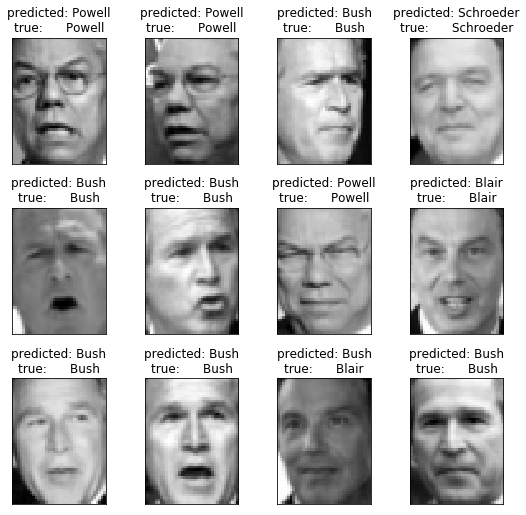

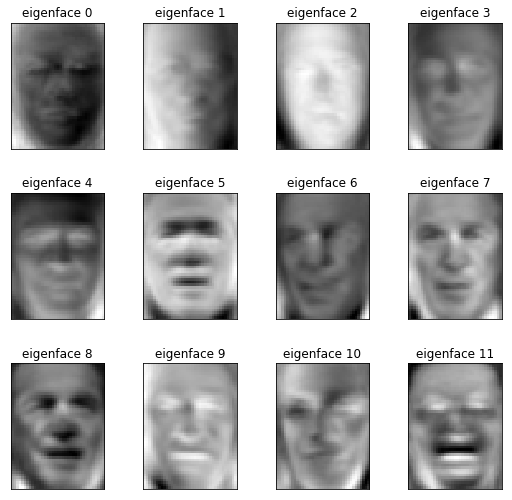

In [17]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib
print("Qualitative evaluation of the predictions using Ensemble model ")
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

print("SHOW Results")
plt.show()

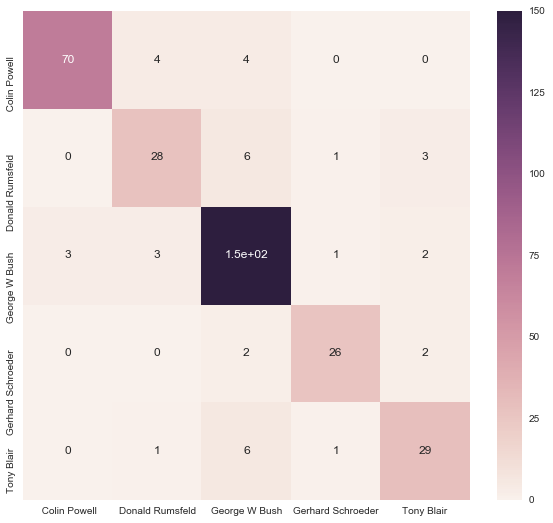

In [20]:
cm=confusion_matrix(y_test,y_pred)
final_labels = [' Colin Powell' ,'Donald Rumsfeld' ,'George W Bush' ,'Gerhard Schroeder','Tony Blair']
df_cm = pd.DataFrame(cm, index = [i for i in final_labels],
                     columns = [i for i in final_labels])
plt.figure(figsize = (10,9))
sn.heatmap(df_cm, annot=True)
plt.show()